In [146]:
import glob
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

from sklearn.ensemble import RandomForestClassifier

from skimage.io import imread
from skimage.transform import resize, rotate
from skimage.feature import hog, canny
from skimage.color import rgb2gray


In [147]:
# Read image filenames
image_names = glob.glob('*.jpg')
image_names.sort()

# Using the OS module
#filenames = [f for f in os.listdir(dataset_folder) if f.endswith('.jpg')]


In [148]:
# Read one image to find dimensions
test_image = imread(image_names[20])

# Define new size of images for speed
rows, cols, bands = test_image.shape

# Define new square size
size = rows//16
print(size)


75


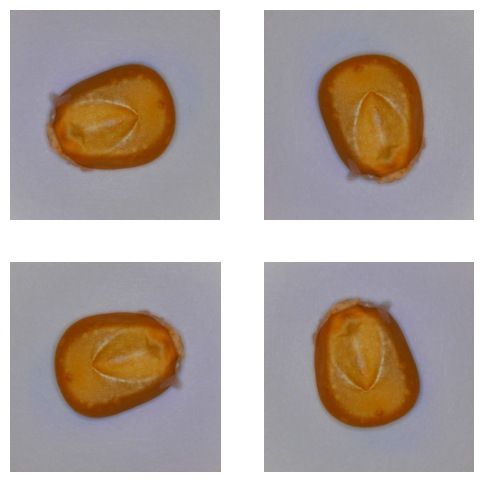

In [149]:
# Cropp and rotate image
test_image = test_image[:,(cols-rows)//2:cols-(cols-rows)//2,:]

plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
plt.imshow(test_image)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(rotate(test_image, 90))
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(rotate(test_image, 180))
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(rotate(test_image, 270))
plt.axis('off')
plt.show()


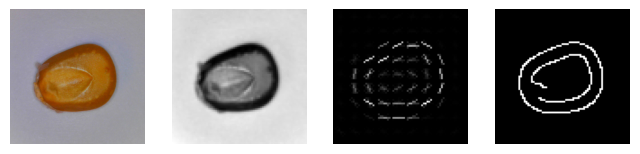

In [150]:
# Compute the histogram of oriented gradients
test_image_resized = rgb2gray(resize(test_image, (size,size), anti_aliasing=True))

# Canny edges
canny_image = canny(test_image_resized, sigma=2.5)

# Compute the histogram of oriented gradients
fv, hog_image = hog(test_image_resized, visualize=True, transform_sqrt=True)

# Create figure to compare outputs
plt.figure(figsize=(8,6))
plt.subplot(1,4,1)
plt.imshow(test_image)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(test_image_resized, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(hog_image, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(canny_image, cmap='gray')
plt.axis('off')

plt.show()


In [151]:
# Check size of feature vector
fv_size = fv.size
print(fv_size)


3969


In [152]:
# Read, resize, and flatten images
image_labels = []
image_numbers = []
#X = np.empty((len(image_names)*4, fv_size + 3 ), float)
X = np.empty((len(image_names)*4, size*size ), float)

for k,name in enumerate(image_names):
    
    # Extract number and species label
    name_parts = glob.os.path.splitext(name)
    number, label = name_parts[0].split('_')
    
    # Read and resize RGB image
    rgb = resize(imread(name), (size, size, 3), anti_aliasing=True)
    
    for angle in [0, 90, 180, 270]:
        rgb_rotated = rotate(rgb, angle)
        
        # Mean color
        R_avg = np.median(rgb_rotated[20:50,20:50,0])
        G_avg = np.median(rgb_rotated[20:50,20:50,1])
        B_avg = np.median(rgb_rotated[20:50,20:50,2])
        
        # Convert RGB image to grayscale
        im = rgb2gray(rgb_rotated)

        # Greyscale image
        #X[k,:] = im.flatten()

        # Compute the feature vector using HOG
        #fv = hog(im, visualize=False, feature_vector=True, transform_sqrt=True)
        
        # Canny edge detection
        #canny_image = canny(im)

        # Add feature vector to input matrix X
        #X[k,:] = np.concatenate((fv, [R_avg], [G_avg], [B_avg]))
        X[k,:] = im.flatten()
        image_numbers.append(number)
        image_labels.append(label)


In [153]:
# Create array to keep track of image order
indices = np.arange(len(image_labels))

# Stratified split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, image_labels, indices,
                                                    test_size=0.3, 
                                                    stratify=image_labels, 
                                                    random_state=1)



In [154]:
# Scale data to range between 0 and 1
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [155]:
# Train the logistic model
LR_model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
print('Train score:', LR_model.score(X_train, y_train))

# Test of the logistic model
LR_test = LR_model.predict(X_test)
print('Test score:', LR_model.score(X_test, y_test))


Train score: 0.35714285714285715
Test score: 0.25


In [156]:
# Train the SGD Classifier
SGD_model = SGDClassifier().fit(X_train, y_train)
print('Train score:', SGD_model.score(X_train, y_train))

# Test of the SGD Classifier
SGD_test = SGD_model.predict(X_test)
print('Test score:', SGD_model.score(X_test, y_test))


Train score: 0.23660714285714285
Test score: 0.20833333333333334


In [158]:
# Train the Random Forest Classifier
RF_model = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)
print('Train score:', RF_model.score(X_train, y_train))

# Test of the RF Classifier
RF_test = RF_model.predict(X_test)
print('Test score:', RF_model.score(X_test, y_test))



Train score: 0.35714285714285715
Test score: 0.23958333333333334


In [60]:
# Multi-layer perceptron
y_dense = LabelBinarizer().fit_transform(image_labels)

# Stratified split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y_dense, indices,
                                                    test_size=0.3, 
                                                    stratify=image_labels, 
                                                    random_state=1)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [69]:
mlp = MLPClassifier(solver='lbfgs', activation='logistic', learning_rate='adaptive',
                    learning_rate_init=0.01, hidden_layer_sizes=(500, 2),
                    random_state=2, max_iter=1000)
mlp.fit(X_train, y_train)
#mlp.predict(X_test);

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))


Training set score: 0.254464
Test set score: 0.145833


/Users/andrespatrignani/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [159]:
# Show the observed and predicted labels
for k,label in enumerate(y_test):
    if (label != LR_test[k]) or (label != SGD_test[k]):
        flag = '***'
    else:
        flag = ''
        
    print(f"{k} Image {image_numbers[index_test[k]]} => Observed:{label}  Pred:{RF_test[k]}  {flag}")
    

0 Image 051 => Observed:oilseedsunflower  Pred:lentils  ***
1 Image 038 => Observed:buffalobur  Pred:lentils  ***
2 Image 034 => Observed:buffalobur  Pred:lentils  ***
3 Image 026 => Observed:flax  Pred:lentils  ***
4 Image 029 => Observed:flax  Pred:lentils  ***
5 Image 043 => Observed:prosomillet  Pred:lentils  ***
6 Image 037 => Observed:buffalobur  Pred:lentils  ***
7 Image 026 => Observed:flax  Pred:lentils  ***
8 Image 030 => Observed:flax  Pred:lentils  ***
9 Image 069 => Observed:lentils  Pred:lentils  ***
10 Image 075 => Observed:commonlambsquarters  Pred:lentils  ***
11 Image 039 => Observed:buffalobur  Pred:lentils  ***
12 Image 064 => Observed:grainsorghum  Pred:lentils  ***
13 Image 026 => Observed:flax  Pred:lentils  ***
14 Image 046 => Observed:prosomillet  Pred:lentils  ***
15 Image 020 => Observed:popcorn  Pred:rice  ***
16 Image 075 => Observed:commonlambsquarters  Pred:lentils  ***
17 Image 020 => Observed:popcorn  Pred:rice  ***
18 Image 036 => Observed:buffalobur  

/var/folders/w1/cgh8d8y962g9c6p4_dxgbn2jh5jy11/T/ipykernel_25514/1298807954.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.where(np.asarray(crop_values) == 'F')


(array([], dtype=int64),)

In [78]:
len(year_values)

24

In [41]:
import numpy as np

In [43]:
cmap = plt.colormaps.get_cmap('tab20')
month_colors = cmap(np.linspace(0, 1, 12))

In [22]:
wf_crop = [9,9,9]
wf_fallow = [15,15,15]
print(sum(wf_crop) + sum(wf_fallow))
print(sum(wf_crop)/72*100, sum(wf_fallow)/72*100)

72
37.5 62.5


In [24]:
wfs_crop = [9,6,9,6]
wfs_fallow = [11,10,11,10]
print(sum(wfs_crop) + sum(wfs_fallow))
print(sum(wfs_crop)/72*100, sum(wfs_fallow)/72*100)

72
41.66666666666667 58.333333333333336
